In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-win_amd64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-win_amd64.whl (99.8 MB)


In [4]:
#importing required libraries 

import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import time
import seaborn as sns

from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
import xgboost as xgb

# Boosting Algorithm Libraries :
from sklearn.ensemble import RandomForestRegressor

In [5]:
test = pd.read_csv(r'Dataset\test.csv')
train = pd.read_csv(r'Dataset\train.csv')

## Data information in train dataframe

In [7]:
def data_inf(data,name):
    print('rows: ',data.shape[0],' ,columns: ',data.shape[1],' in',name,'\n')
    data.info()
    print('\n')
data_inf(train,'Train')
display(train.head(5))

rows:  48120  ,columns:  4  in Train 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB




,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


## Data information in test dataframe

In [8]:
data_inf(test,"Test")
display(test.head(5))

rows:  11808  ,columns:  3  in Test 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11808 entries, 0 to 11807
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  11808 non-null  object
 1   Junction  11808 non-null  int64 
 2   ID        11808 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 276.9+ KB




,DateTime,Junction,ID
0,2017-07-01 00:00:00,1,20170701001
1,2017-07-01 01:00:00,1,20170701011
2,2017-07-01 02:00:00,1,20170701021
3,2017-07-01 03:00:00,1,20170701031
4,2017-07-01 04:00:00,1,20170701041


## Data description

In [9]:
display(train.describe())
display(train.describe(include = 'object'))

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


,DateTime
count,48120
unique,14592
top,2017-06-30 23:00:00
freq,4


## drop duplicate rows in train data

In [10]:
print('before dropping ',train.shape[0])
train.drop_duplicates(keep="first", inplace=True) 
print('after dropping ',train.shape[0])

before dropping  48120
after dropping  48120


## check for missing values and fill them if there

In [11]:
if(train.isnull().sum().sum()==0):
    print('no missing values in train')
else:
    train.fillna(method='ffill',inplace=True)
if(test.isnull().sum().sum()==0):
    print('no missing values in test')    
else:
    test.fillna(method='ffill',inplace=True)

no missing values in train
no missing values in test


## Converting datetime column into datetime 

In [12]:
print('before converting :',train['DateTime'].dtype)
train['DateTime'] = pd.to_datetime(train['DateTime'])
test['DateTime'] = pd.to_datetime(test['DateTime'])
print('after converting :',train['DateTime'].dtype)

before converting : object
after converting : datetime64[ns]


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
 3   ID        48120 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.5 MB


<h2>Feature Engineering</h2>
<h3>Extracting important features from datetime column</h3>

In [14]:
# Exploring more features  
train["Year"]= train['DateTime'].dt.year  
train["Month"]= train['DateTime'].dt.month  
train["Date_no"]= train['DateTime'].dt.day  
train["Hour"]= train['DateTime'].dt.hour  
train["Day"]= train.DateTime.dt.strftime("%A")

test["Year"]= test['DateTime'].dt.year  
test["Month"]= test['DateTime'].dt.month  
test["Date_no"]= test['DateTime'].dt.day  
test["Hour"]= test['DateTime'].dt.hour  
test["Day"]= test.DateTime.dt.strftime("%A")

In [15]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


In [16]:
test.head()

,DateTime,Junction,ID,Year,Month,Date_no,Hour,Day
0,2017-07-01 00:00:00,1,20170701001,2017,7,1,0,Saturday
1,2017-07-01 01:00:00,1,20170701011,2017,7,1,1,Saturday
2,2017-07-01 02:00:00,1,20170701021,2017,7,1,2,Saturday
3,2017-07-01 03:00:00,1,20170701031,2017,7,1,3,Saturday
4,2017-07-01 04:00:00,1,20170701041,2017,7,1,4,Saturday


## Data Visualization 

c:\Users\Tejas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Tejas\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'DateTime')

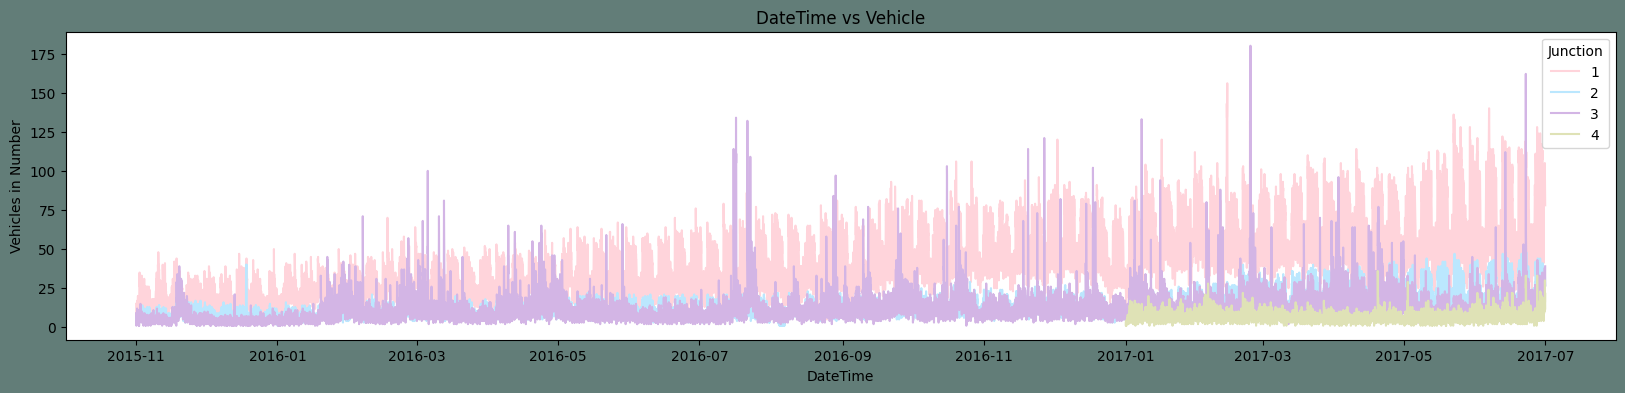

In [17]:
# time series plot
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,4),facecolor="#627D78")  
time_series=sns.lineplot(x=train['DateTime'],y="Vehicles",data=train, hue="Junction", palette=colors)  
time_series.set_title("DateTime vs Vehicle")  
time_series.set_ylabel("Vehicles in Number")  
time_series.set_xlabel("DateTime") 

Text(0.5, 0, 'Date')

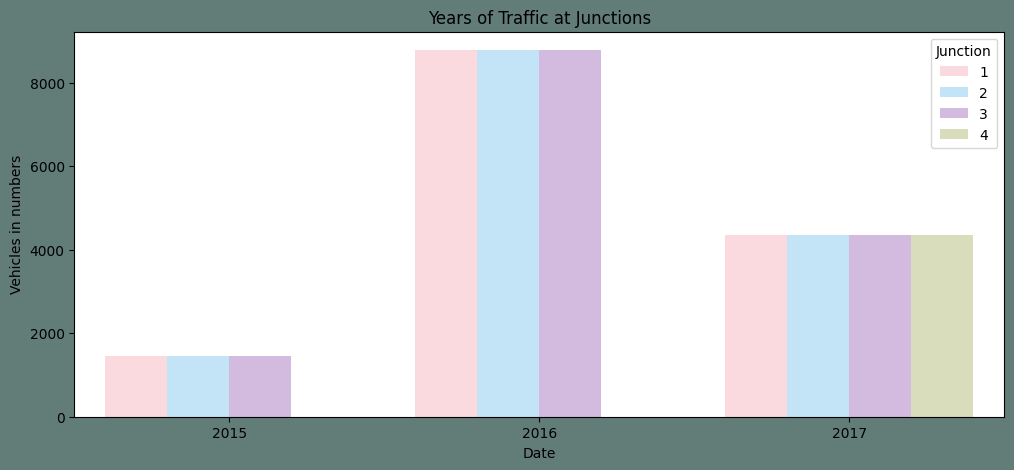

In [18]:
#years of traffic at junction
plt.figure(figsize=(12,5),facecolor="#627D78")  
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
count = sns.countplot(data=train, x =train["Year"], hue="Junction", palette=colors)  
count.set_title("Years of Traffic at Junctions")  
count.set_ylabel("Vehicles in numbers")  
count.set_xlabel("Date") 

## split the train data

In [20]:
def datetounix1(df):
    # Initialising unixtime list
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

In [21]:
train.head()

,DateTime,Junction,Vehicles,ID,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,Sunday


In [22]:
train_features = datetounix1(train.drop(['Vehicles'], axis=1))
test_features = datetounix1(test)


# Store Features / Predictors in array :
X = train_features  
X_valid = test_features

# One Hot Encoding - Using Dummies :
X = pd.get_dummies(X)
X_valid = pd.get_dummies(X_valid)

# Store target 'Vehicles' in y array :
y = train['Vehicles'].to_frame()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=512)

# LGBM Regression

In [23]:
# Convert the dataset to LightGBM data format
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameters for the LightGBM regression model
params = {
    'objective': 'regression',
    'metric': 'rmse'  # Root Mean Squared Error
}

# Train the LightGBM regression model
model = lgb.train(params,train_data, num_boost_round=100)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 602
[LightGBM] [Info] Number of data points in the train set: 32240, number of used features: 14
[LightGBM] [Info] Start training from score 22.676458
Mean Squared Error: 26.130020507003152
Mean Absolute Error: 2.9299309567160123
R2 Score: 0.9407083622016995


# Random Forest regressor

In [24]:
# Create a Random Forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)
#for i in range(15880):
#    print(y_pred[i],y_test.iloc[i])

c:\Users\Tejas\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [25]:
# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Printing the evaluation metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R2 Score:", r2)

Mean Squared Error: 15.770556801007558
Mean Absolute Error: 2.5105428211586904
R2 Score: 0.9642150245740428
